## Experiments



There are essentially two approaches that can be taken when desiring semantically similar samples to a given input: 
1. The first approach is regularizing the autoencoder in such a way that certain geometric properties are retained in the latent representation space. The research paper REGULARIZED AUTOENCODERS FOR ISOMETRIC REPRESENTATION LEARNING by Lee et. al 2022 explore this approach through isometric representation learning. 
- The results of that paper will be used to program the IRVAE.
2. The second approach utilizes the current variational autoencoder (VAE) implementations and instead tries to understand how the geometry of the latent space has changed in regards to the manifold. Specifically, most researchers view the data manifold as a Riemannian manifold, where distances are no longer Euclidean. Therefore, Riemannian metrics have to be used in order to properly determine distances between points in latent space and their respective points when projected onto the manifold. Some of the prominent papers researching this are:
- LATENT SPACE ODDITY: ON THE CURVATURE OF DEEP GENERATIVE MODELS - Arvanitidis et. al 2017
- Only Bayes should learn a manifold  - Hauberg 2018
- Metrics for Deep Generative Models - Chen et. al 2018
- Fast and Robust Shortest Paths on Manifolds Learned from Data - Arvanitidis et. al 2019 
- Geometrically Enriched Latent Spaces - Arvanitidis et. al 2020
- Mario Plays on a Manifold: Generating Functional Content in Latent Space through Differential Geometry - Gonzalez-Duque et. al 2022
- Identifying latent distances with Finslerian geometry - Pouplin et. al 2023
- Decoder ensembling for learned latent geometries - Syrota et. al 2024

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        ]
    )

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=0)

print(f"Using device: {device}")

Using device: cpu


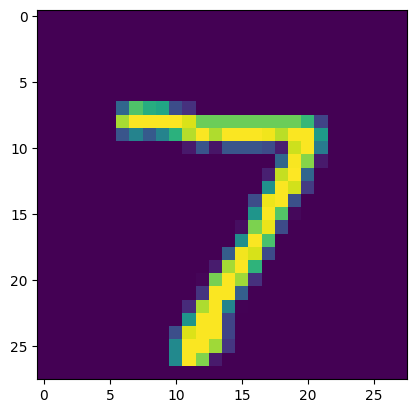

In [2]:
x_test, y_test = next(iter(test_loader))
plt.imshow(x_test.reshape((28, 28, 1)))

## Simple VAE

In [3]:
if not os.path.exists("./pretrained_models/vae.pth"):
    raise KeyError("You need to run the training notebook first.")

from models.vae import VariationalAutoencoder

hidden_dim = 2
vae = VariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], hidden_dim=hidden_dim).to(device)
vae.load_state_dict(torch.load("./pretrained_models/vae.pth", map_location=device, weights_only=True))

<All keys matched successfully>

In [54]:
from collections import defaultdict

vals = defaultdict(list)

vae.eval()
with torch.no_grad():
    for x, y in train_loader:
        _, z, _, _ = vae(x)
        for i in range(len(y)):
            y_val = y[i].item()
            vals[y_val].append(z[i])

### Chart over Latent Space for VAE

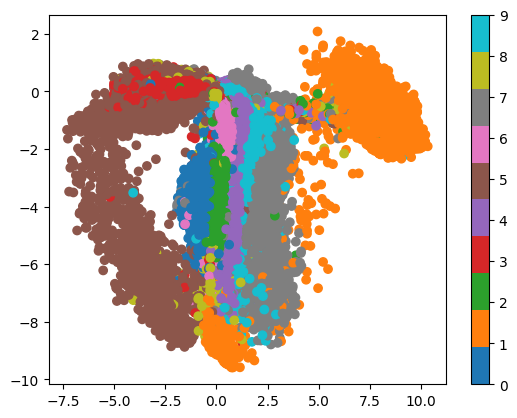

In [4]:
from utils.visualize import visualize_points_in_latent_space
visualize_points_in_latent_space(vae, train_loader)

### Gaussian Sampling of VAE

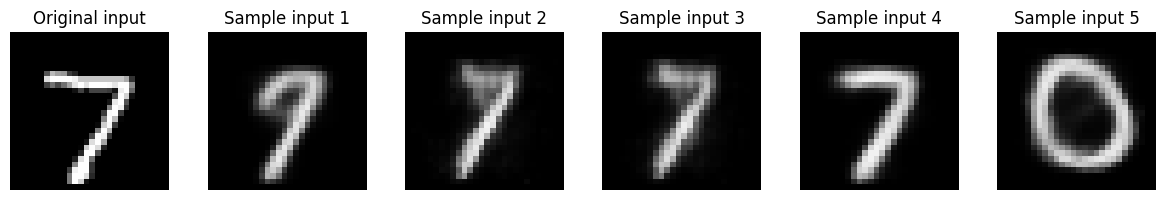

In [64]:
from utils.sampling import gaussian_sampling
from utils.visualize import visualize_samples
gaussian_samples = gaussian_sampling(vae, x_test, device, num_samples=5, scale=5e3) 

visualize_samples(x_test, gaussian_samples)

### Metric-Aware Sampling of VAE

Curve 0 has geodesic length: 2.0840237140655518
Curve 1 has geodesic length: 5.0410237312316895
Curve 2 has geodesic length: 2.335552215576172
Curve 3 has geodesic length: 1.1619369983673096
Curve 4 has geodesic length: 0.5313839912414551


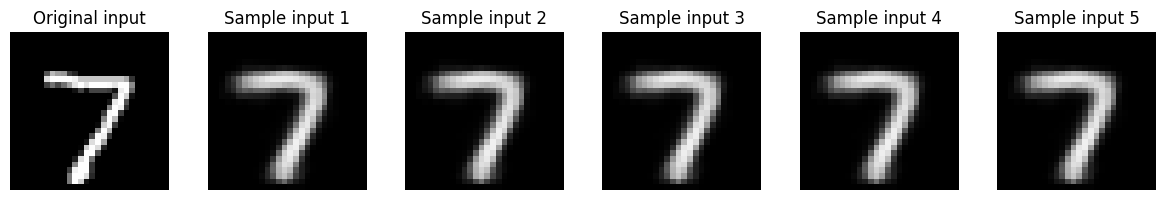

In [57]:
from utils.sampling import geodesic_sampling_close
from utils.visualize import visualize_samples

samples = geodesic_sampling_close(vae, vals, x_test, 7, torch.device("cpu"), num_samples=5)
visualize_samples(x_test, samples)

Curve 0 has geodesic length: 2.0826668739318848
Curve 1 has geodesic length: 5.038588523864746
Curve 2 has geodesic length: 2.3352038860321045
Curve 3 has geodesic length: 1.1626231670379639
Curve 4 has geodesic length: 0.5309970378875732


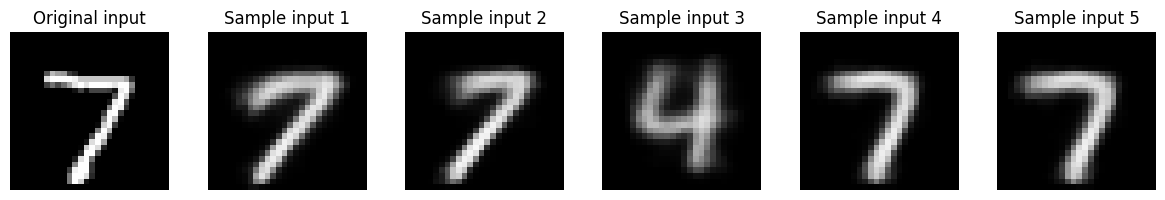

In [65]:
from utils.sampling import geodesic_sampling_whole
from utils.visualize import visualize_samples

samples = geodesic_sampling_whole(vae, vals, x_test, 7, torch.device("cpu"), num_samples=5)
visualize_samples(x_test, samples)

## VAE with RBF for uncertainty

In [6]:
import os
if not os.path.exists("./pretrained_models/vae.pth"):
    raise KeyError("You need to run the training notebook first.")

from models.vae import VariationalAutoencoder
from models.rbf import RBFNet

import numpy as np

hidden_dim = 2
vae = VariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], hidden_dim=hidden_dim).to(device)
vae.load_state_dict(torch.load("./pretrained_models/vae.pth", map_location=device, weights_only=True))

z_train_np = torch.load("pretrained_models/z_train.pt")
num_clusters = 16
a = 0.85

rbf = RBFNet(z_train_np, output_dim=28*28, K=num_clusters, a=a)
rbf.load_state_dict(torch.load("pretrained_models/RBF.pth"))

<All keys matched successfully>

### Gaussian Sampling

The VAE is the same trained model as the last section.

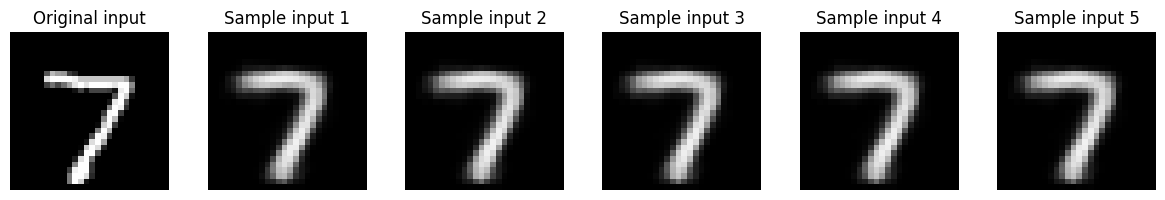

In [7]:
from utils.sampling import gaussian_sampling
from utils.visualize import visualize_samples
gaussian_samples = gaussian_sampling(vae, x_test, device, num_samples=5, scale=1e2) # I should be getting pretty close to the original input as samples... 

visualize_samples(x_test, gaussian_samples)

### Gaussian Sampling of Output
Since the decoder now explicitly contains variance, we can leverage this to sample from a Gaussian with mean from the mean decoder and variance from the variance decoder. In other words, unlike the simple VAE, the Gaussian will have heteroscedastic variance, dependent on the input.

[tensor([[[1.9599e-02, 4.1061e-02, 1.9458e-02, 3.5287e-02, 1.8109e-02,
          1.9330e-02, 1.9785e-02, 3.1862e-02, 2.4500e-02, 4.4898e-02,
          1.8819e-02, 2.0027e-02, 1.8844e-02, 2.5969e-02, 1.8649e-02,
          1.8973e-02, 1.9865e-02, 4.7709e-02, 5.4448e-02, 1.9771e-02,
          4.3999e-02, 3.6815e-02, 1.8556e-02, 3.8618e-02, 5.1644e-02,
          1.9632e-02, 3.1971e-02, 3.3409e-02, 3.9281e-02, 3.0544e-02,
          1.9548e-02, 5.3237e-02, 5.1458e-02, 3.7635e-02, 2.8909e-02,
          2.1021e-02, 1.8605e-02, 2.0363e-02, 1.8851e-02, 7.9235e-03,
          5.6751e-02, 2.3142e-02, 5.5025e-02, 2.2443e-02, 1.7709e-02,
          3.5735e-02, 1.9452e-02, 1.9030e-02, 1.8823e-02, 3.0342e-03,
          2.2075e-02, 3.4101e-02, 5.1228e-02, 1.8825e-02, 1.8897e-02,
          2.0330e-02, 1.9729e-02, 1.9817e-02, 5.2931e-02, 3.1101e-02,
          2.1164e-02, 2.7718e-02, 3.7490e-02, 3.1457e-02, 1.8152e-02,
          4.7838e-02, 3.4195e-02, 1.1167e-03, 2.8736e-02, 1.2952e-03,
          5.7280e-0

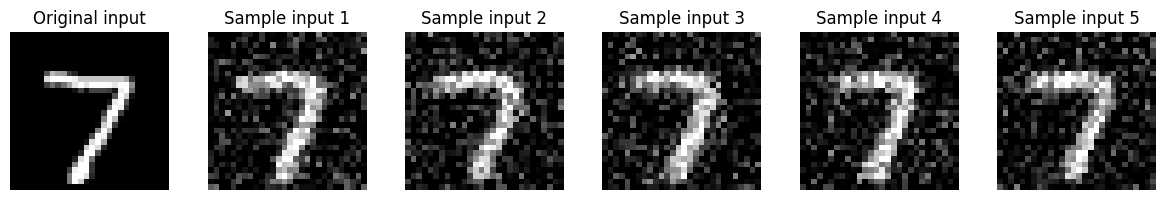

In [12]:
from utils.sampling import gaussian_sampling_rbf
from utils.visualize import visualize_samples

# x_hat, z, _, _ = vae(x_test)
# print(rbf(z).shape)
# print(x_hat.shape)
gaussian_samples = gaussian_sampling_rbf(vae, rbf, x_test, device, num_samples=5, scale=0.2) # I should be getting pretty close to the original input as samples... 
# rbf()
visualize_samples(x_test, gaussian_samples)

### Metric-Aware Sampling
Here, the random manifold created from the uncertainty in the decoder function removes problems with a smoother manifold. As shown in research such as that proposed in the Differential Geometry textbook by Hauberg, deterministic manifolds are smoother (one of the goals and therefore side effects of regularizing neural networks). However, with smoother manifolds, holes and valleys that should appear in areas without data makes geodesics and the Riemannian metric inconsistent/incorrect. However, it was found that random manifolds come closer to the true manifold in this sense by stretching the distances in areas with higher uncertainty. This motivates geodesics to form on the manifold in low uncertainty areas. Still, the metric from such manifolds was shown to not be Riemannian in nature but rather Finslerian (shown by Pouplin et. al 2023).

## Gaussian-VAE

## Isometric Representation VAE (IRVAE)

In [4]:
from models.irvae import IRVAE

hidden_dim = 2
irvae = IRVAE([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28]).to(device)
irvae.load_state_dict(torch.load("./pretrained_models/irvae.pth", map_location=device, weights_only=True))

<All keys matched successfully>

In [5]:
from collections import defaultdict

vals = defaultdict(list)

irvae.eval()
with torch.no_grad():
    for x, y in train_loader:
        _, z, _, _ = irvae(x)
        for i in range(len(y)):
            y_val = y[i].item()
            vals[y_val].append(z[i])

### Chart over Latent space for IRVAE

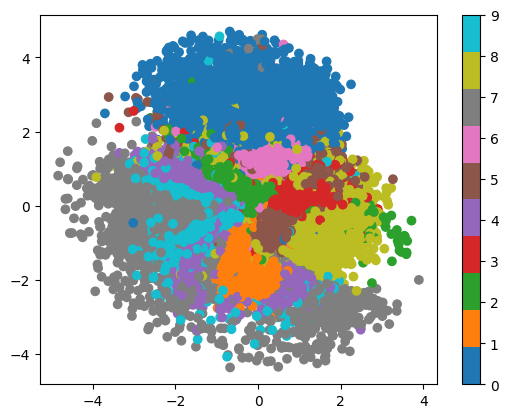

In [14]:
from utils.visualize import visualize_points_in_latent_space
visualize_points_in_latent_space(irvae, train_loader)

### Gaussian Sampling of IRVAE

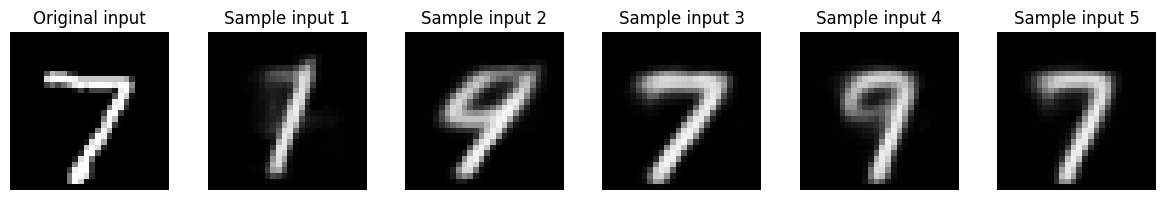

In [ ]:
from utils.sampling import gaussian_sampling
from utils.visualize import visualize_samples
gaussian_samples = gaussian_sampling(irvae, x_test, device, num_samples=5, scale=3e1) 

visualize_samples(x_test, gaussian_samples)

### Metric-aware Sampling of IRVAE

Curve 0 has geodesic length: 1.0912610292434692
Curve 1 has geodesic length: 5.176825523376465
Curve 2 has geodesic length: 1.0397237539291382
Curve 3 has geodesic length: 1.1757915019989014
Curve 4 has geodesic length: 0.3194759488105774


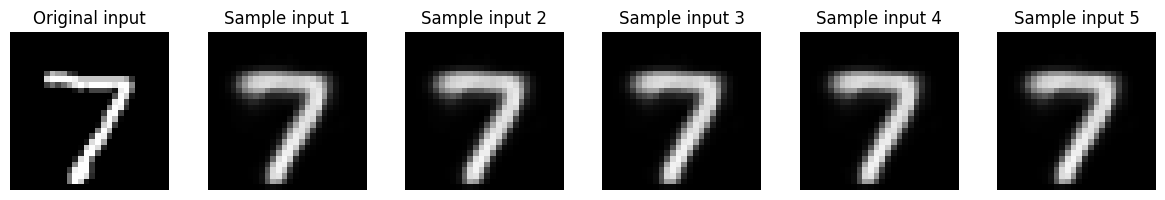

In [6]:
from utils.sampling import geodesic_sampling_close
from utils.visualize import visualize_samples

samples = geodesic_sampling_close(irvae, vals, x_test, 7, torch.device("cpu"), num_samples=5)
visualize_samples(x_test, samples)

Curve 0 has geodesic length: 1.0534138679504395
Curve 1 has geodesic length: 5.208810806274414
Curve 2 has geodesic length: 1.082620620727539
Curve 3 has geodesic length: 1.2093008756637573
Curve 4 has geodesic length: 0.3644278049468994


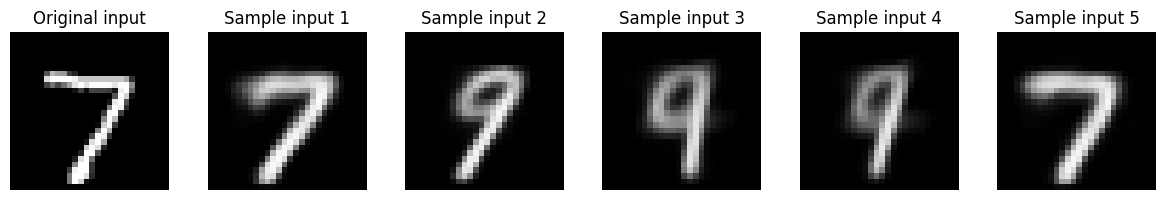

In [7]:
from utils.sampling import geodesic_sampling_whole
from utils.visualize import visualize_samples

samples = geodesic_sampling_whole(irvae, vals, x_test, 7, torch.device("cpu"), num_samples=5)
visualize_samples(x_test, samples)

## Conditional Variational Autoencoder (CVAE)
TODO in the future

Future direction:

Uncertainty using distance measures
    - Use a precomputed table of the locations of the input data and class on the latent space chart. Then, compare the intraclass and interclass distance of a given test point in the latent space (the prediction of the predictive model is used to check the "class"). Find a good clustering distance measure, so I can compare. If the intraclass distance is high and interclass distance (or distance to a single other class) is low, there should be higher uncertainty and vice versa.
    - Do the same, but compute the geodesic between everypoint. Maybe I can cache the Jacobians for the training data to save time? If not, I will need to use the whole training set to compute just one geodesic.
